In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
sys.path.append("..") # relative path to module toolkit

In [3]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [4]:
# setup
batch_size = 3
train_dir = "../../images/images_genus/train/"
val_dir = "../../images/images_genus/val/"
train_images = 12525
val_images = 3454
save_model_name = "restnet50pretrained.h5"
save_plot_name = "resnet50pretrained_trainplot.png"

In [5]:
steps_per_epoch = int(train_images/batch_size) + 1
validation_steps = int(val_images/batch_size) + 1

In [6]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet')

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# add the outplut layer
predictions = Dense(44, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

for layer in model.layers:
    layer.trainable = True

/usr/local/lib/python2.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])


In [9]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)

Found 12263 images belonging to 44 classes.
Found 3381 images belonging to 44 classes.


In [11]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/25
4176/4176 [==============================] - 726s 174ms/step - loss: 0.8874 - acc: 0.7380 - val_loss: 0.3280 - val_acc: 0.8990
Epoch 2/25
4176/4176 [==============================] - 725s 174ms/step - loss: 0.2396 - acc: 0.9233 - val_loss: 0.2602 - val_acc: 0.9201
Epoch 3/25
4176/4176 [==============================] - 695s 166ms/step - loss: 0.1097 - acc: 0.9668 - val_loss: 0.2348 - val_acc: 0.9392
Epoch 4/25
4176/4176 [==============================] - 695s 167ms/step - loss: 0.0801 - acc: 0.9747 - val_loss: 0.1399 - val_acc: 0.9606
Epoch 5/25
4176/4176 [==============================] - 695s 166ms/step - loss: 0.0437 - acc: 0.9864 - val_loss: 0.0930 - val_acc: 0.9742
Epoch 6/25
4176/4176 [==============================] - 695s 167ms/step - loss: 0.0280 - acc: 0.9925 - val_loss: 0.0964 - val_acc: 0.9760
Epoch 7/25
4176/4176 [==============================] - 695s 166ms/step - loss: 0.0249 - acc: 0.9924 - val_loss: 0.1091 - val_acc: 0.9664
Epoch 8/25
4176/4176 [============

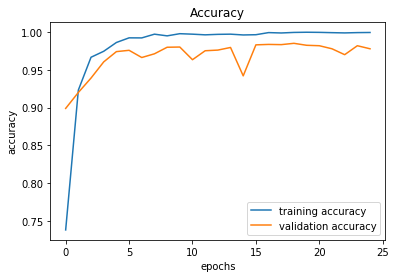

In [12]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()

In [13]:
#save
model.save(save_model_name)